## Library imports

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # visualization
import matplotlib.pyplot as plt # visualization

## Setup data directories

In [2]:
# if you are running a kaggle notebook
DATA_DIR = "/kaggle/input"
OUTPUT_DIR = "/kaggle/output"

In [3]:
# if you are running it on local machine
# download input files
# create directory kaggle/input
os.makedirs("input/titanic", exist_ok=True)
os.makedirs("output/titanic", exist_ok=True)
# # download files from kaggle
# !kaggle competitions download --force -c titanic -p input
# !unzip -d input/titanic kaggle/input/titanic.zip
DATA_DIR = "input/titanic"
OUTPUT_DIR = "output/titanic"

In [4]:
# if you are running it on kaggle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input/titanic/test.csv
input/titanic/gender_submission.csv
input/titanic/train.csv


In [5]:

train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

## Handle missing data

In [6]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

As we can see there are three fields with missing values. We will care aout fillig missing `Age` and `Embarked` data while drop `Cabin` Data.

### Fill missing age values

len(train_df['Age']):891
train_df['Age'].median:28.0
train_df['Age'].mean:29.69911764705882


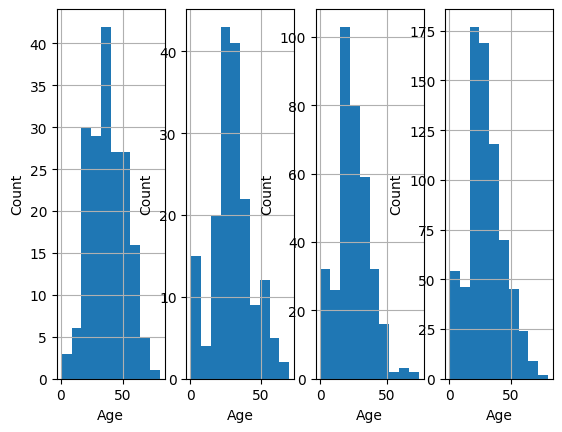

In [7]:
print(f"len(train_df['Age']):{len(train_df['Age'])}")
print(f"train_df['Age'].median:{train_df['Age'].median(skipna=True)}")
print(f"train_df['Age'].mean:{train_df['Age'].mean(skipna=True)}")
# train_df['Age'].describe()
# ax = titanic_df["Age"].hist(bins=15, color='teal', alpha=0.8)
# ax.set(xlabel='Age', ylabel='Count')
plt.subplot(1,4,1)
ax1 = train_df[train_df["Pclass"]==1]["Age"].hist()
ax1.set(xlabel='Age', ylabel='Count')
plt.subplot(1,4,2)
ax2=train_df[train_df["Pclass"]==2]["Age"].hist()
ax2.set(xlabel='Age', ylabel='Count')
plt.subplot(1,4,3)
ax3=train_df[train_df["Pclass"]==3]["Age"].hist()
ax3.set(xlabel='Age', ylabel='Count')
plt.subplot(1,4,4)
ax4 = train_df["Age"].hist()
ax4.set(xlabel='Age', ylabel='Count')
plt.show()

As we can see the age distibution is right skewed we prefer median insstead of mean

In [8]:
class_mean_age_map= train_df.groupby("Pclass")["Age"].aggregate("mean").to_dict()
class_median_age_map = train_df.groupby("Pclass")["Age"].aggregate("median").to_dict()
print(f"class_mean_age_map: {class_mean_age_map}")
print(f"class_median_age_map: {class_median_age_map}")

class_mean_age_map: {1: 38.233440860215055, 2: 29.87763005780347, 3: 25.14061971830986}
class_median_age_map: {1: 37.0, 2: 29.0, 3: 24.0}


In [9]:
# populate missing ages by median age of class in both train and test_df
train_df["Age"] = train_df["Age"].fillna(train_df["Pclass"].map(class_median_age_map))
test_df["Age"] = test_df["Age"].fillna(test_df["Pclass"].map(class_median_age_map))


### Populate missing `Embarked`

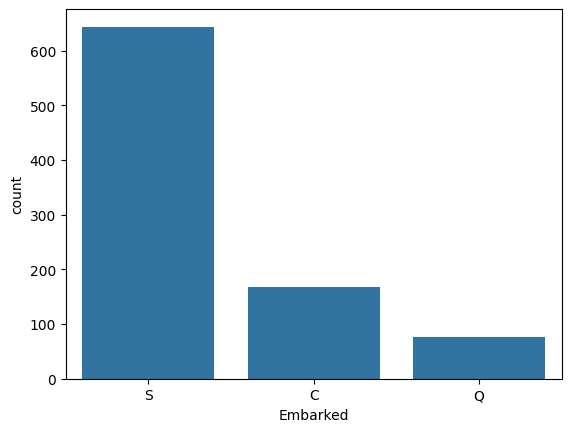

In [10]:
sns.countplot(x='Embarked',data=train_df, legend=False)
plt.show()

As we can see most of the people embarked from `S` we can fill missing values by `S`

In [11]:
train_df.fillna({"Embarked":"S"}, inplace=True)
test_df.fillna({"Embarked":"S"}, inplace=True)

### Drop Cabin values

In [12]:
train_df.drop('Cabin', axis=1, inplace=True)
test_df.drop('Cabin', axis=1, inplace=True)

In [13]:
# Recheck for null values
train_df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### References
1. [DataFrame.isna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html)
2. [DataFrame.hist](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.hist.html)
3. [seaborn.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html)

# Feature Engineering

### Age vs survival

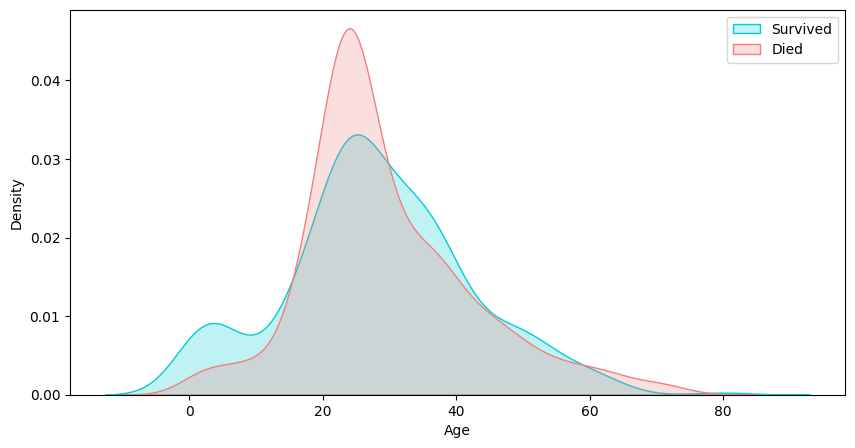

In [14]:
# plot kde for age vs survival
plt.figure(figsize=(10,5))
sns.kdeplot(train_df["Age"][train_df.Survived == 1], color="darkturquoise", fill=True)
sns.kdeplot(train_df["Age"][train_df.Survived == 0], color="lightcoral", fill=True)
plt.legend(['Survived', 'Died'])
plt.show()

## Co-travellers vs survival

relatives  Survived
0          0           0.696462
           1           0.303538
1          1           0.552795
           0           0.447205
2          1           0.578431
           0           0.421569
3          1           0.724138
           0           0.275862
4          0           0.800000
           1           0.200000
5          0           0.863636
           1           0.136364
6          0           0.666667
           1           0.333333
7          0           1.000000
10         0           1.000000
Name: proportion, dtype: float64


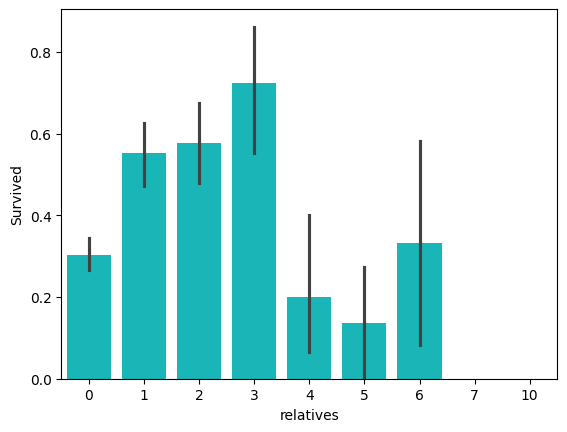

In [15]:
train_df["SibSp"].value_counts()
train_df["Parch"].value_counts()
train_df["relatives"] = train_df["SibSp"] + train_df["Parch"]
print(train_df[["relatives", "Survived"]].groupby("relatives").value_counts(normalize=True)) #

sns.barplot(x='relatives', y='Survived', data=train_df, color="darkturquoise")
plt.show()

## Pclass vs survival

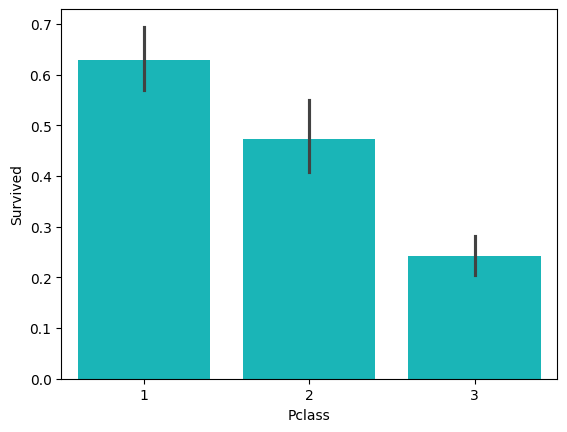

In [16]:
sns.barplot(x='Pclass', y='Survived', data=train_df, color="darkturquoise")
plt.show()

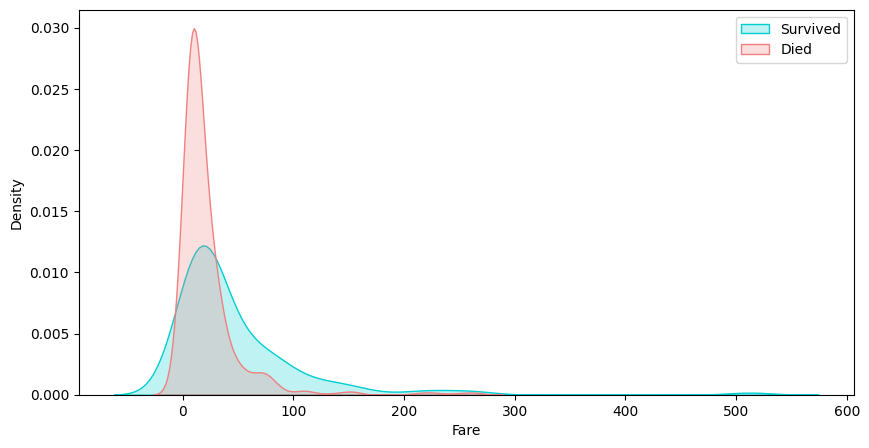

In [17]:
plt.figure(figsize=(10,5))
sns.kdeplot(train_df["Fare"][train_df.Survived == 1], color="darkturquoise", fill=True)
sns.kdeplot(train_df["Fare"][train_df.Survived == 0], color="lightcoral", fill=True)
plt.legend(['Survived', 'Died'])
plt.show()

## gender vs survival

Sex     Survived
female  1           0.742038
        0           0.257962
male    0           0.811092
        1           0.188908
Name: proportion, dtype: float64


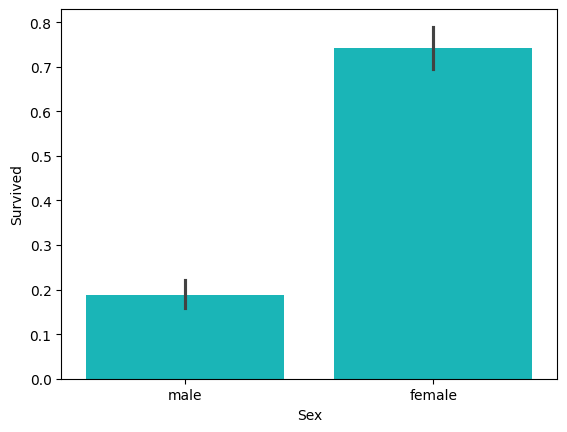

In [18]:
print(train_df[["Sex", "Survived"]].groupby("Sex").value_counts(normalize=True)) #
sns.barplot(x='Sex', y='Survived', data=train_df, color="darkturquoise")
plt.show()

Embarked  Survived
C         1            93
          0            75
Q         0            47
          1            30
S         0           427
          1           219
Name: count, dtype: int64


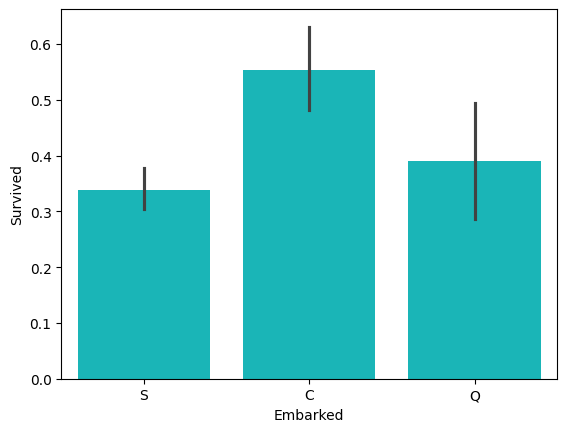

In [19]:
# Embarked vs survival
print(train_df[["Embarked", "Survived"]].groupby("Embarked").value_counts()) #
sns.barplot(x='Embarked', y='Survived', data=train_df, color="darkturquoise")
plt.show()

## Observations
1. Age as an absolute number doesn"t seem to have a direct correlation with surivival. However `Survived` outnumber the "Died" from 0-16. This suggest there might be concious attempt to save children. We use this observation to make a more useful feature `isMinor`.
2. We observe Surivived/Deceased ratio of people travelling alone is 7:3. So we can create another feture `isTravellingAlone`
3. Pclass 1 has higher survival ratio which is also correlated to fare paid. People who paid higher `Fare` were more likely to survive.
4. Female/Male survival ratio(.74 vs .18) suggests that females were more likey to be offered rescue oppurtunities. 

## Feature modifications


In [20]:
def modify_df(df):
    # add field isMinor
    df["isMinor"] = df["Age"].apply(lambda x: 1 if x<16 else 0)
    df["relatives"] = df["SibSp"] + df["Parch"]
    # add field isTravellingAlone
    df["isTravellingAlone"] = df["relatives"].apply(lambda x: 1 if x<=0 else 0)
    # merge Sex column as isFemale
    df["isFemale"] = df["Sex"].apply(lambda x: 1 if x=="female" else 0)
    # drop columns age, relatives, SibSp, Parch
    df.drop(['Name', 'Ticket', 'Age', 'Sex', 'SibSp', 'Parch','Ticket','relatives'], axis=1, inplace=True)
    return df
train_df = modify_df(train_df)
test_df = modify_df(test_df)
# train_df["isMinor"].value_counts()
# pd.get_dummies(train_df)
train_df.head(2)

,PassengerId,Survived,Pclass,Fare,Embarked,isMinor,isTravellingAlone,isFemale
0,1,0,3,7.2500,S,0,0,0
1,2,1,1,71.2833,C,0,0,1


## Classification using Decision tree


### Visualization

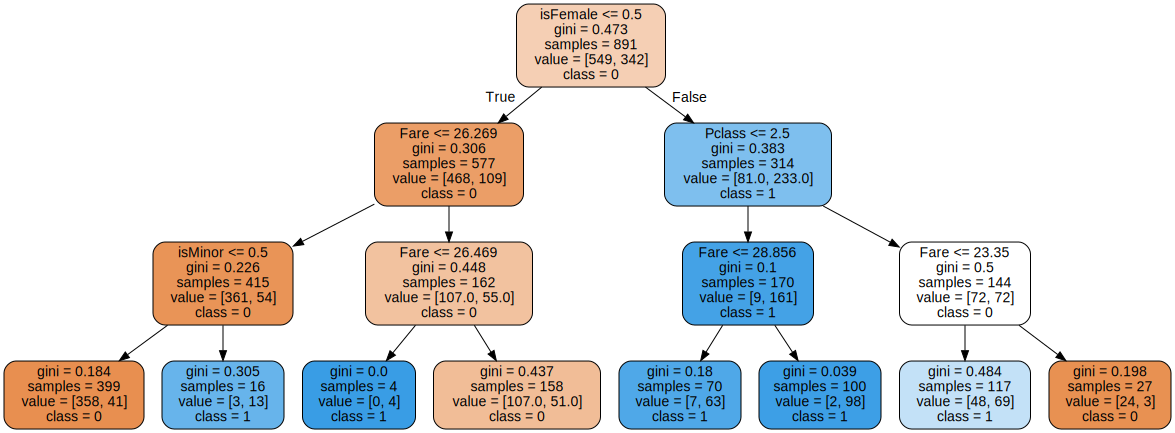

In [21]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source


# iris = load_iris(as_frame=True)
features = ["Fare", "Pclass", "isFemale", "isTravellingAlone", "isMinor"]


X_titanic = train_df[features]
# convert categorcial values to numeric
X_titanic = pd.get_dummies(X_titanic)

dummy_features = list(X_titanic.columns)
X_titanic = X_titanic.values
y_titanic = train_df["Survived"]



tree_clf = DecisionTreeClassifier(max_depth=3, random_state=1)
tree_clf.fit(X_titanic, y_titanic)

export_graphviz(
        tree_clf,
        out_file=str(f"{OUTPUT_DIR}/titanic_tree.dot"),
        feature_names=dummy_features,
        class_names=["0","1"],
        rounded=True,
        filled=True
    )

Source.from_file(f"{OUTPUT_DIR}/titanic_tree.dot") 

In [22]:
# predict values
# test_df = test_df[features]
# X_titanic = train_df[features]
# # convert categorcial values to numeric
# X_titanic = pd.get_dummies(X_titanic)
# dummy_features = list(X_titanic.columns)
# # features = X_titanic.feature_names
# X_titanic = X_titanic.values
# y_titanic = train_df["Survived"]

X_titanic_test = test_df[features]
X_titanic_test = pd.get_dummies(X_titanic_test)
dumm_features = list(X_titanic_test.columns)
X_titanic_test = X_titanic_test.values
X_titanic_test
Y_titanic_predictions = tree_clf.predict(X_titanic_test)
output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': Y_titanic_predictions})
# output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Classification using Random forests

In [23]:
from sklearn.ensemble import RandomForestClassifier

y = train_df["Survived"]

features = ["Fare", "Pclass", "isFemale", "isTravellingAlone", "isMinor"]
# Convert categorical variable into dummy/indicator variables.
X = pd.get_dummies(train_df[features])
X_test = pd.get_dummies(test_df[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=120)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# References
1. [Skewness](https://en.wikipedia.org/wiki/Skewness)
2. [Pandas reference](https://pandas.pydata.org/pandas-docs/stable/reference/)
3. [Kernel density estimation](https://seaborn.pydata.org/tutorial/distributions.html#tutorial-kde)